<a href="https://colab.research.google.com/github/anustupdas/document-sucject-classification/blob/main/Raw_Data_Exploration_Base_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw Data exploration and Base model trainig Notebook


**This Notebook will enable you to play with the Raw Training data and have a good idea about the distribution of the raw data before preprocessing. Moreover you can also train a basic version of a subject classification model with Huggingface Transformers model and also inference the model with text data.**

In [ ]:
%%capture
!pip install transformers
!pip install torch

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Util Functions

In [ ]:
def get_df_from_dict(meta_dict):
  metadata_df_list = []
  mt_du = meta_dict

  for key in mt_du.keys():
    file_count = len(mt_du[key])
    max_word_count = max(mt_du[key])
    min_word_count = min(mt_du[key])
    avg_word_count = np.mean(mt_du[key])
    files_below_10_words = sum(i < 10 for i in mt_du[key])
    files_below_512_words = sum(i < 512 for i in mt_du[key])
    files_above_1000_words = sum(i > 1000 for i in mt_du[key])
    files_above_3000_words = sum(i > 3000 for i in mt_du[key])
    k = (key , file_count,max_word_count,min_word_count,int(avg_word_count),files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words)
    metadata_df_list.append(k)

  metadata_df = pd.DataFrame(metadata_df_list, columns=['Category','file_count','max_word_count', 'min_word_count','avg_word_count','files_below_10_words','files_below_512_words','files_above_1000_words','files_above_3000_words'])
  return metadata_df

def get_metadata_from_df(data_frame):

  metadata_dict = {}
  for index, row in data_frame.iterrows():
    #print(row['category'], row['count'])
    if row['category'] not in metadata_dict.keys():
      metadata_dict[row['category']] = []
    metadata_dict[row['category']].append(row['count'])



  return get_df_from_dict(metadata_dict)


In [ ]:
def plot_bar_chart(metadata_df, key_to_sort, small_first= False):

  metadata_df = metadata_df.sort_values(key_to_sort, ascending=small_first)
  category_count = metadata_df['Category'].value_counts()

  categories = category_count.index

  fig = plt.figure(figsize= (120, 50))

  ax = fig.add_subplot(111)

  sns.barplot(x = categories, y = metadata_df[key_to_sort] )

  for a, p in enumerate(ax.patches):
      ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

  plt.xlabel('Categories', size = 15)

  plt.ylabel('The Number of News', size= 15)

  plt.xticks(size = 12)

  plt.title("The number of News by Categories" , size = 18)

  plt.show()


## Starting Point

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
datapath = '/content/drive/MyDrive/medior-data-scientist-case-study/raw_data/main_data_subject_classification_summary.csv'
df = pd.read_csv(datapath)
df[:100]

,Unnamed: 0,file_name,text,summary,category
0,0,20230408.txt,Answered on page 2 Reader Response on Tragedy ...,answered on page reader response on tragedy ma...,English
1,1,37349149.txt,Discuss the following: The four (4) most impor...,discuss the following: the four most important...,English
2,2,13352763.txt,Salika Tejani Tejani1 Dr. Wright ENGL. 1302 21...,salika tejani tejani1 dr. wright engl. 1302 21...,English
3,3,52094821.txt,Life 2e Intermediate Book Answer Key UNIT 1 2 ...,life 2e intermediate book answer key unit nort...,English
4,4,51170973.txt,9 English Quarter 4 Module 2 (Weeks 2 and 3) P...,english quarter module (weeks and purpose and ...,English
...,...,...,...,...,...
95,95,2887320.txt,1. Describe the dimensions of a culture that y...,describe the dimensions of culture that you ar...,Sociology
96,96,2887317.txt,1. What are the differences between social gro...,what are the differences between social groups...,Sociology
97,97,2887321.txt,1. Describe examples of research that support ...,describe examples of research that support the...,Sociology
98,98,1875986.txt,The danger of a single story is that it the di...,the danger of single story is that it the dign...,Sociology


# Histogram of the count of text

<Axes: xlabel='category'>

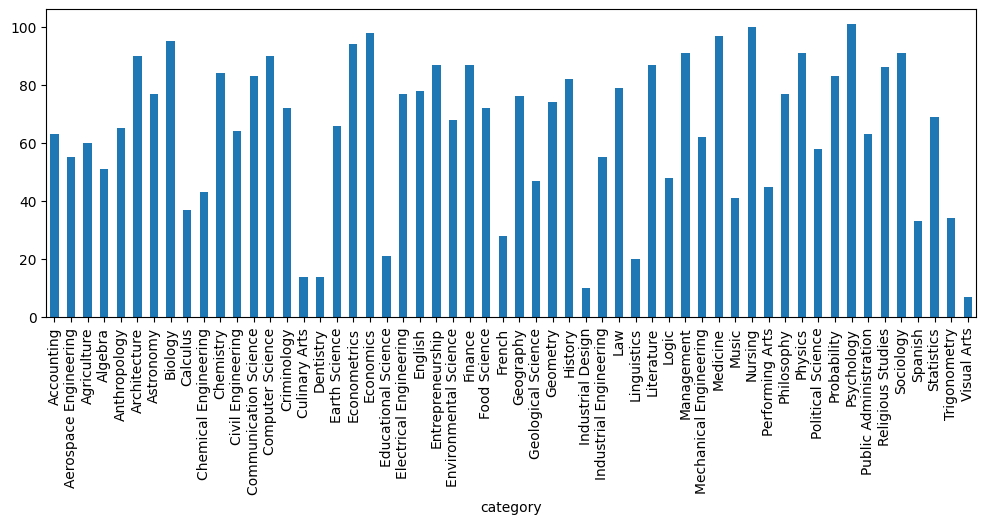

In [ ]:
df.groupby(['category']).size().plot.bar(figsize = (12, 4))

In [ ]:
df['count'] = df['text'].apply(lambda x: len(x.split()))
df['summary_count'] = df['summary'].apply(lambda x: len(str(x).split()))

In [ ]:
df.head()

,Unnamed: 0,file_name,text,summary,category,count,summary_count
0,0,20230408.txt,Answered on page 2 Reader Response on Tragedy ...,answered on page reader response on tragedy ma...,English,549,32
1,1,37349149.txt,Discuss the following: The four (4) most impor...,discuss the following: the four most important...,English,377,30
2,2,13352763.txt,Salika Tejani Tejani1 Dr. Wright ENGL. 1302 21...,salika tejani tejani1 dr. wright engl. 1302 21...,English,465,26
3,3,52094821.txt,Life 2e Intermediate Book Answer Key UNIT 1 2 ...,life 2e intermediate book answer key unit nort...,English,30118,30
4,4,51170973.txt,9 English Quarter 4 Module 2 (Weeks 2 and 3) P...,english quarter module (weeks and purpose and ...,English,6773,28


<Figure size 800x800 with 0 Axes>

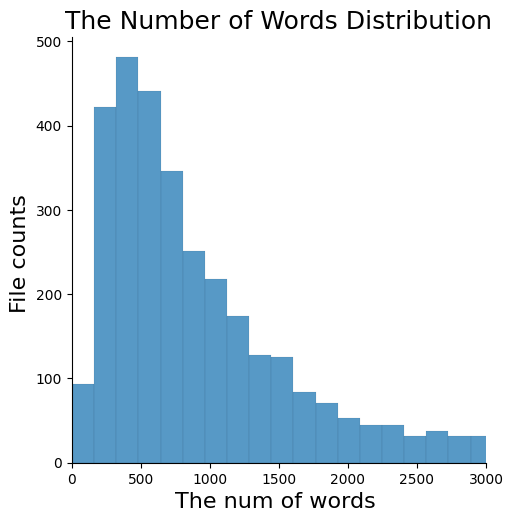

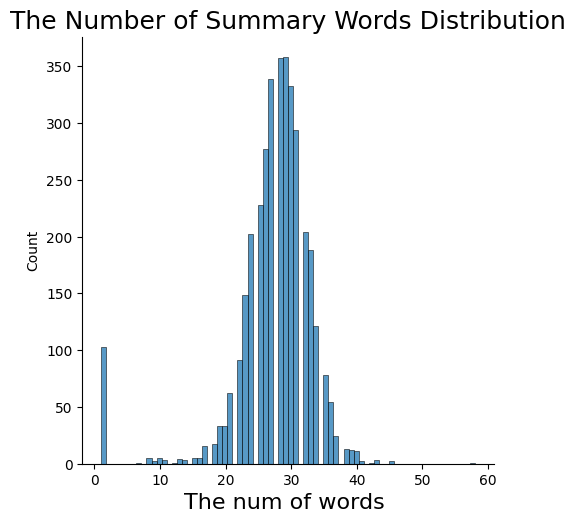

In [ ]:
plt.figure(figsize= (8, 8))


sns.displot(df['count'])
plt.xlim(0, 3000)
plt.xlabel('The num of words ', fontsize = 16)
plt.ylabel('File counts ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
sns.displot(df['summary_count'])
plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Summary Words Distribution", fontsize = 18)
plt.show()


**A word count distribution plot for a whole corpus is a graphical representation of the frequency of words in
the corpus, arranged according to the number of times they appear in the corpus. In this plot, the x-axis represents
 the number of times a word appears in the corpus, while the y-axis represents the number of words that appear that many times.
The plot can be used to identify the most common words in the corpus and determine the overall shape and characteristics of the corpus. It can also be compared to similar plots for other corpora to identify patterns and trends in language use.**

# Bar plot for each of the new category

In [ ]:
metadata_df = get_metadata_from_df(df)
metadata_df.head()

,Category,file_count,max_word_count,min_word_count,avg_word_count,files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words
0,English,78,65336,110,2804,0,29,25,11
1,Dentistry,14,4219,259,1492,0,4,8,3
2,Sociology,91,16974,62,1738,0,18,33,9
3,Accounting,63,24892,41,3008,0,16,36,14
4,French,28,8023,3,795,2,18,7,1


Example Usage:



```
# plot_bar_chart(meta-data-frame, 'column-name-to-sort-for', small_first = False)
```



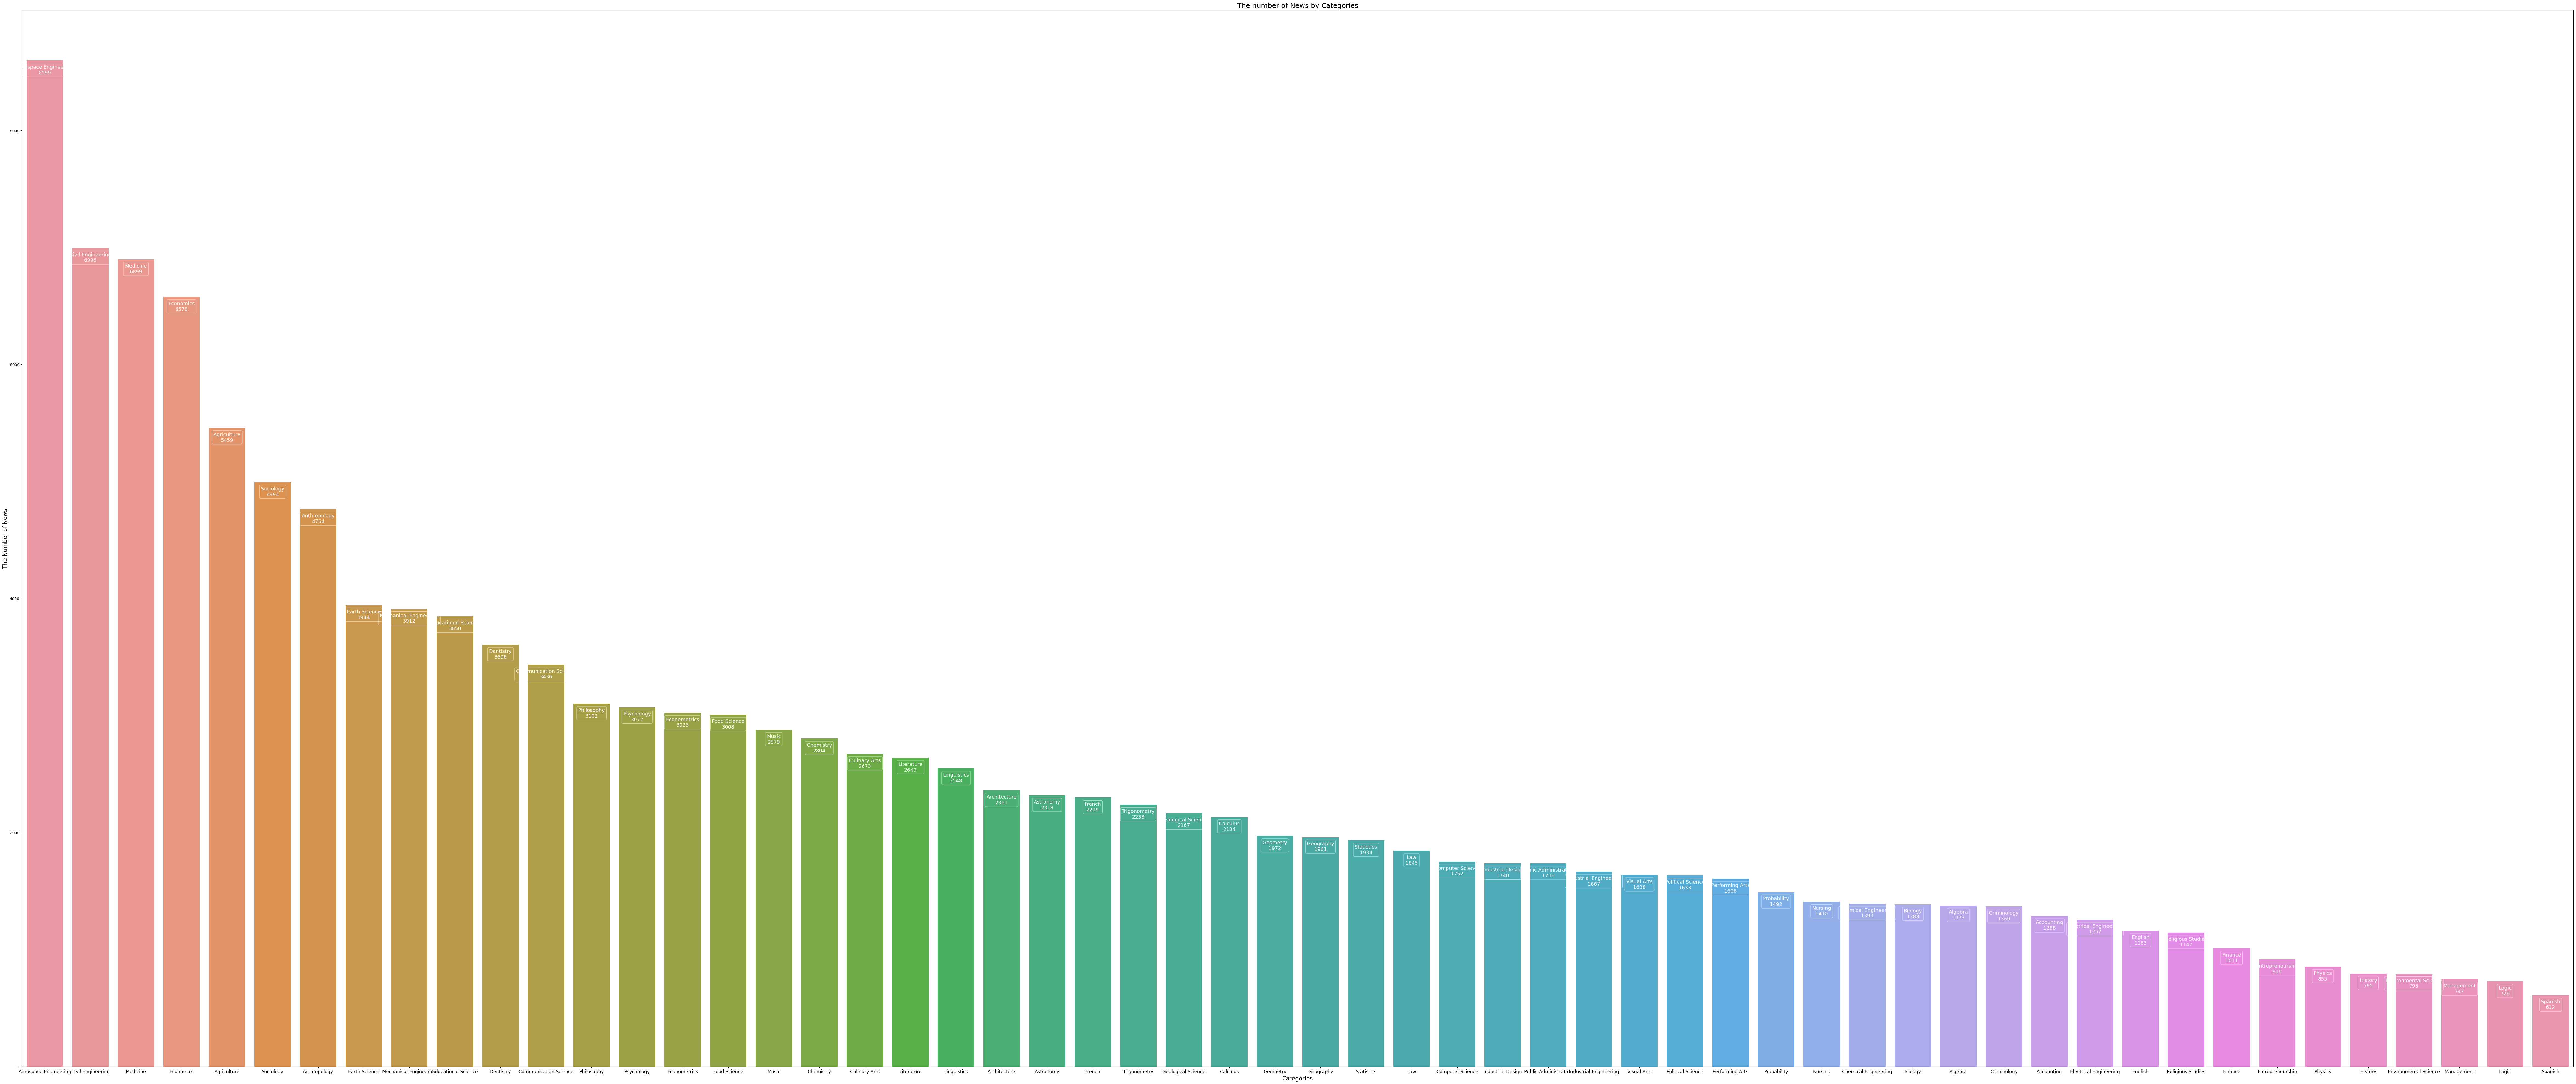

In [ ]:
plot_bar_chart(metadata_df, 'avg_word_count', small_first = False)

In [ ]:
metadata_df = metadata_df.sort_values('avg_word_count', ascending=False)
metadata_df[:20]

,Category,file_count,max_word_count,min_word_count,avg_word_count,files_below_10_words,files_below_512_words,files_above_1000_words,files_above_3000_words
8,Aerospace Engineering,55,85115,208,8599,0,15,29,16
49,Civil Engineering,64,70182,12,6996,0,13,39,23
13,Computer Science,90,73838,150,6899,0,18,51,28
6,Industrial Design,10,59621,247,6578,0,5,3,1
21,Public Administration,63,55524,346,5459,0,4,54,22
16,Industrial Engineering,55,74770,243,4994,0,5,31,12
33,Visual Arts,7,8727,523,4764,0,0,5,4
29,Political Science,58,64902,104,3944,0,6,40,17
42,Performing Arts,45,81661,77,3912,0,26,14,5
45,Probability,83,67534,110,3850,0,27,38,14


# Data Preparation

In [ ]:
print(f"No of Categories: {len(df['category'].unique())}")
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)


label_dict = {}
for i in df['category'].unique():
  idx = list(df['category'].values).index(i)
  label_code = df['encoded_text'][idx]
  label_dict[label_code] = i


No of Categories: 56


In [ ]:
data_texts = df['text'].to_list()

data_labels = df['encoded_text'].to_list()

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True )

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Fine-tuning with the TFTrainer class

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=56)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
checkpoint_path = '/content/checkpoint_model'
checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_acc", mode="max",save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased',
                                                              num_labels=56)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)

#compile the model
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

#train the model
model.fit(train_dataset.shuffle(100).batch(16),
              epochs=10,
              batch_size=16,
              callbacks=callbacks,
              validation_data=val_dataset.shuffle(100).batch(16))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
182/182 [==============================] - ETA: 0s - loss: 3.2436 - accuracy: 0.2414 

182/182 [==============================] - 11534s 63s/step - loss: 3.2436 - accuracy: 0.2414 - val_loss: 2.3339 - val_accuracy: 0.4431
Epoch 2/10
182/182 [==============================] - ETA: 0s - loss: 1.7795 - accuracy: 0.5793 

182/182 [==============================] - 11487s 63s/step - loss: 1.7795 - accuracy: 0.5793 - val_loss: 1.5872 - val_accuracy: 0.6022
Epoch 3/10
182/182 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.7534  

182/182 [==============================] - 11797s 65s/step - loss: 1.0564 - accuracy: 0.7534 - val_loss: 1.3536 - val_accuracy: 0.6557
Epoch 4/10
182/182 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.8276  

182/182 [==============================] - 11936s 66s/step - loss: 0.7115 - accuracy: 0.8276 - val_loss: 1.2635 - val_accuracy: 0.6927


### Saving the model

In [ ]:
!mkdir saved_models

In [ ]:
save_directory = "/content/checkpoint_model"

model.save_pretrained(os.path.join(save_directory)

tokenizer.save_pretrained(os.path.join(save_directory)

# Inference with saved and loaded model

In [ ]:
test_text = "La mission s'est achevée samedi au stade Ataturk Olimpiyat d'Istanbul alors que le club soutenu par Abu Dhabi a remporté le titre de la Ligue des champions pour la première fois et a peut-être annoncé le début d'une nouvelle ère de domination dans la compétition."

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis = 1).numpy()[0]

print(f"{test_text} is probably from {label_dict[prediction_value]}")